### Local Modelling
- given the locale's relative SST in the two months leading up to cyclone genesis 
- test two lags (that month and the previous month) to see how 'predictable' it is

In [62]:
import numpy as np
import pandas as pd
from utils.jtwc_cyclone_utils import get_all_cyclones
cyclone_df = get_all_cyclones(one_per_id=True)
cyclone_df


timestamp   Storm ID BASIN  Season  SEASON TC NUMBER  \
911   1982-03-14 06:00:00   1982-N-1    WP  1982.0               1.0   
0     1981-10-21 06:00:00   1982-S-2    SI  1982.0               2.0   
912   1982-03-18 06:00:00   1982-N-2    WP  1982.0               2.0   
1     1981-11-03 18:00:00   1982-S-3    SI  1982.0               3.0   
913   1982-03-28 06:00:00   1982-N-3    WP  1982.0               3.0   
...                   ...        ...   ...     ...               ...   
1877  2022-10-14 06:00:00  2022-N-24    WP  2022.0              24.0   
1878  2022-10-26 00:00:00  2022-N-26    WP  2022.0              26.0   
1879  2022-10-28 12:00:00  2022-N-27    WP  2022.0              27.0   
1880  2022-11-11 18:00:00  2022-N-28    WP  2022.0              28.0   
1881  2022-12-08 00:00:00  2022-N-29    WP  2022.0              29.0   

      Latitude (degrees)  Longitude (degrees)  VMAX (kt)  Peak VMAX (kt)  \
911                  7.1                153.0       15.0            60.0   
0                   -8.0                 84.6       40.0            85.0   
912                  3.8                160.7       25.0           105.0   
1                   -8.6                 92.9       55.0            80.0   
913                  3.5                156.6       20.0            75.0   
...                  ...                  ...        ...             ...   
1877                26.4                154.4       25.0            40.0   
1878                12.2                133.8       20.0            75.0   
1879                 8.0                140.4       25.0            40.0   
1880                20.2                166.3       20.0            40.0   
1881                 6.4                133.1       15.0            50.0   

          ACE  Maximum 24h Intensification  
911   0.73250                         15.0  
0     1.18725                         25.0  
912   2.02800                         25.0  
1     1.08875                         15.0  
913   0.70650                         15.0  
...       ...                          ...  
1877  0.19675                         15.0  
1878  0.67825                         25.0  
1879  0.10875                         15.0  
1880  0.10600                         10.0  
1881  0.17550                         20.0  

[1882 rows x 11 columns]

## Obtaining some SST Variables

- Global 12 month rolling tropical mean -- how much energy is in the global atmosphere right now??
- Local monthly anomaly 

In [63]:
from utils.globals import SI_MIN, SI_MAX, SP_MIN, SP_MAX
from utils.SST_utils import get_historical_ssts, get_tropical_avg
import seaborn as sns
import matplotlib.pyplot as plt

historical_ssts = get_historical_ssts()
# Remove seasonality if possible...
tropical_avg_ssts = get_tropical_avg(historical_ssts)
tropical_avg_ssts
# historical_ssts # 0.2 degree grid
# historical_ssts['rSST'] = historical_ssts['sst'] - tropical_avg_ssts['sst'] don't use rSST


<xarray.Dataset>
Dimensions:  (time: 499)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
Data variables:
    sst      (time) float32 26.89 27.24 27.34 27.35 ... 27.49 27.57 27.77 28.41

#### For each cyclone entry, obtain the smoothed local rSST both in the month of genesis and the preceding month

In [64]:
from utils.cyclone_utils import get_datetime
from utils.SST_utils import get_local_smooth_at_time, sel_mm_yyyyy, get_local_mean


def filter_nan_from_values(list_obj):
    if len(list_obj) == 0:
        return np.nan
    
    return list_obj[0]


## EFFICIENCY CONCERNS???

def curried_local_smooth(lat, lon, time):
    return get_local_smooth_at_time(historical_ssts['sst'], lat,lon, time) 

def curried_local_mean_for_month(lat, lon, time):
    return get_local_mean(historical_ssts['sst'], lat,lon, time) 

# def curried_local_smooth(lat, lon, time):
#     return get_local_smooth_at_time(historical_ssts['sst'], lat,lon, time) 

local_smooth_vectorized = np.vectorize(curried_local_smooth)
local_mean_for_month_vectorized = np.vectorize(curried_local_mean_for_month)


cyclone_df.loc[:,'Tropical SST'] = cyclone_df.apply(
    lambda row: filter_nan_from_values(tropical_avg_ssts['sst'].sel(time=sel_mm_yyyyy(tropical_avg_ssts, get_datetime(row['timestamp']).month, get_datetime(row['timestamp']).year)).values), axis=1)
cyclone_df['Local SST'] = local_smooth_vectorized(cyclone_df['Latitude (degrees)'], cyclone_df['Longitude (degrees)'], cyclone_df['timestamp'])
cyclone_df['Local Month Mean'] = local_mean_for_month_vectorized(cyclone_df['Latitude (degrees)'], cyclone_df['Longitude (degrees)'], cyclone_df['timestamp'])



In [65]:
# ONLY GET TROPICAL LOCATIONS
cyclone_df = cyclone_df.loc[(cyclone_df.loc[:,'Local Month Mean'] >= 27.5) & (cyclone_df.loc[:,'Local SST'] >= 27.5)]
cyclone_df = cyclone_df.dropna(subset=['Tropical SST'])
cyclone_df.to_csv('../cyclone_data/jtwc/cleaned/full_cleaned.csv', index=False)

In [66]:
from utils.jtwc_cyclone_utils import get_saffir_simpson_category

cyclone_df = cyclone_df.dropna(subset=['Tropical SST'], how='any')
cyclone_df['Local Anomaly'] = cyclone_df['Local SST'] - cyclone_df['Local Month Mean']  
cyclone_df['Saffir-Simpson Category'] = cyclone_df['Peak VMAX (kt)'].apply(get_saffir_simpson_category)

data_of_interest=cyclone_df.loc[:, [
    'BASIN', 'Longitude (degrees)', 'Latitude (degrees)','Tropical SST',
    'Local Anomaly','Local Month Mean', 'Local SST', 'Peak VMAX (kt)','Saffir-Simpson Category', 'ACE', 'Maximum 24h Intensification'
    ] ]
# cyclone_df.to_csv('../cyclone_data/jtwc/cleaned/full_sst_means.csv')



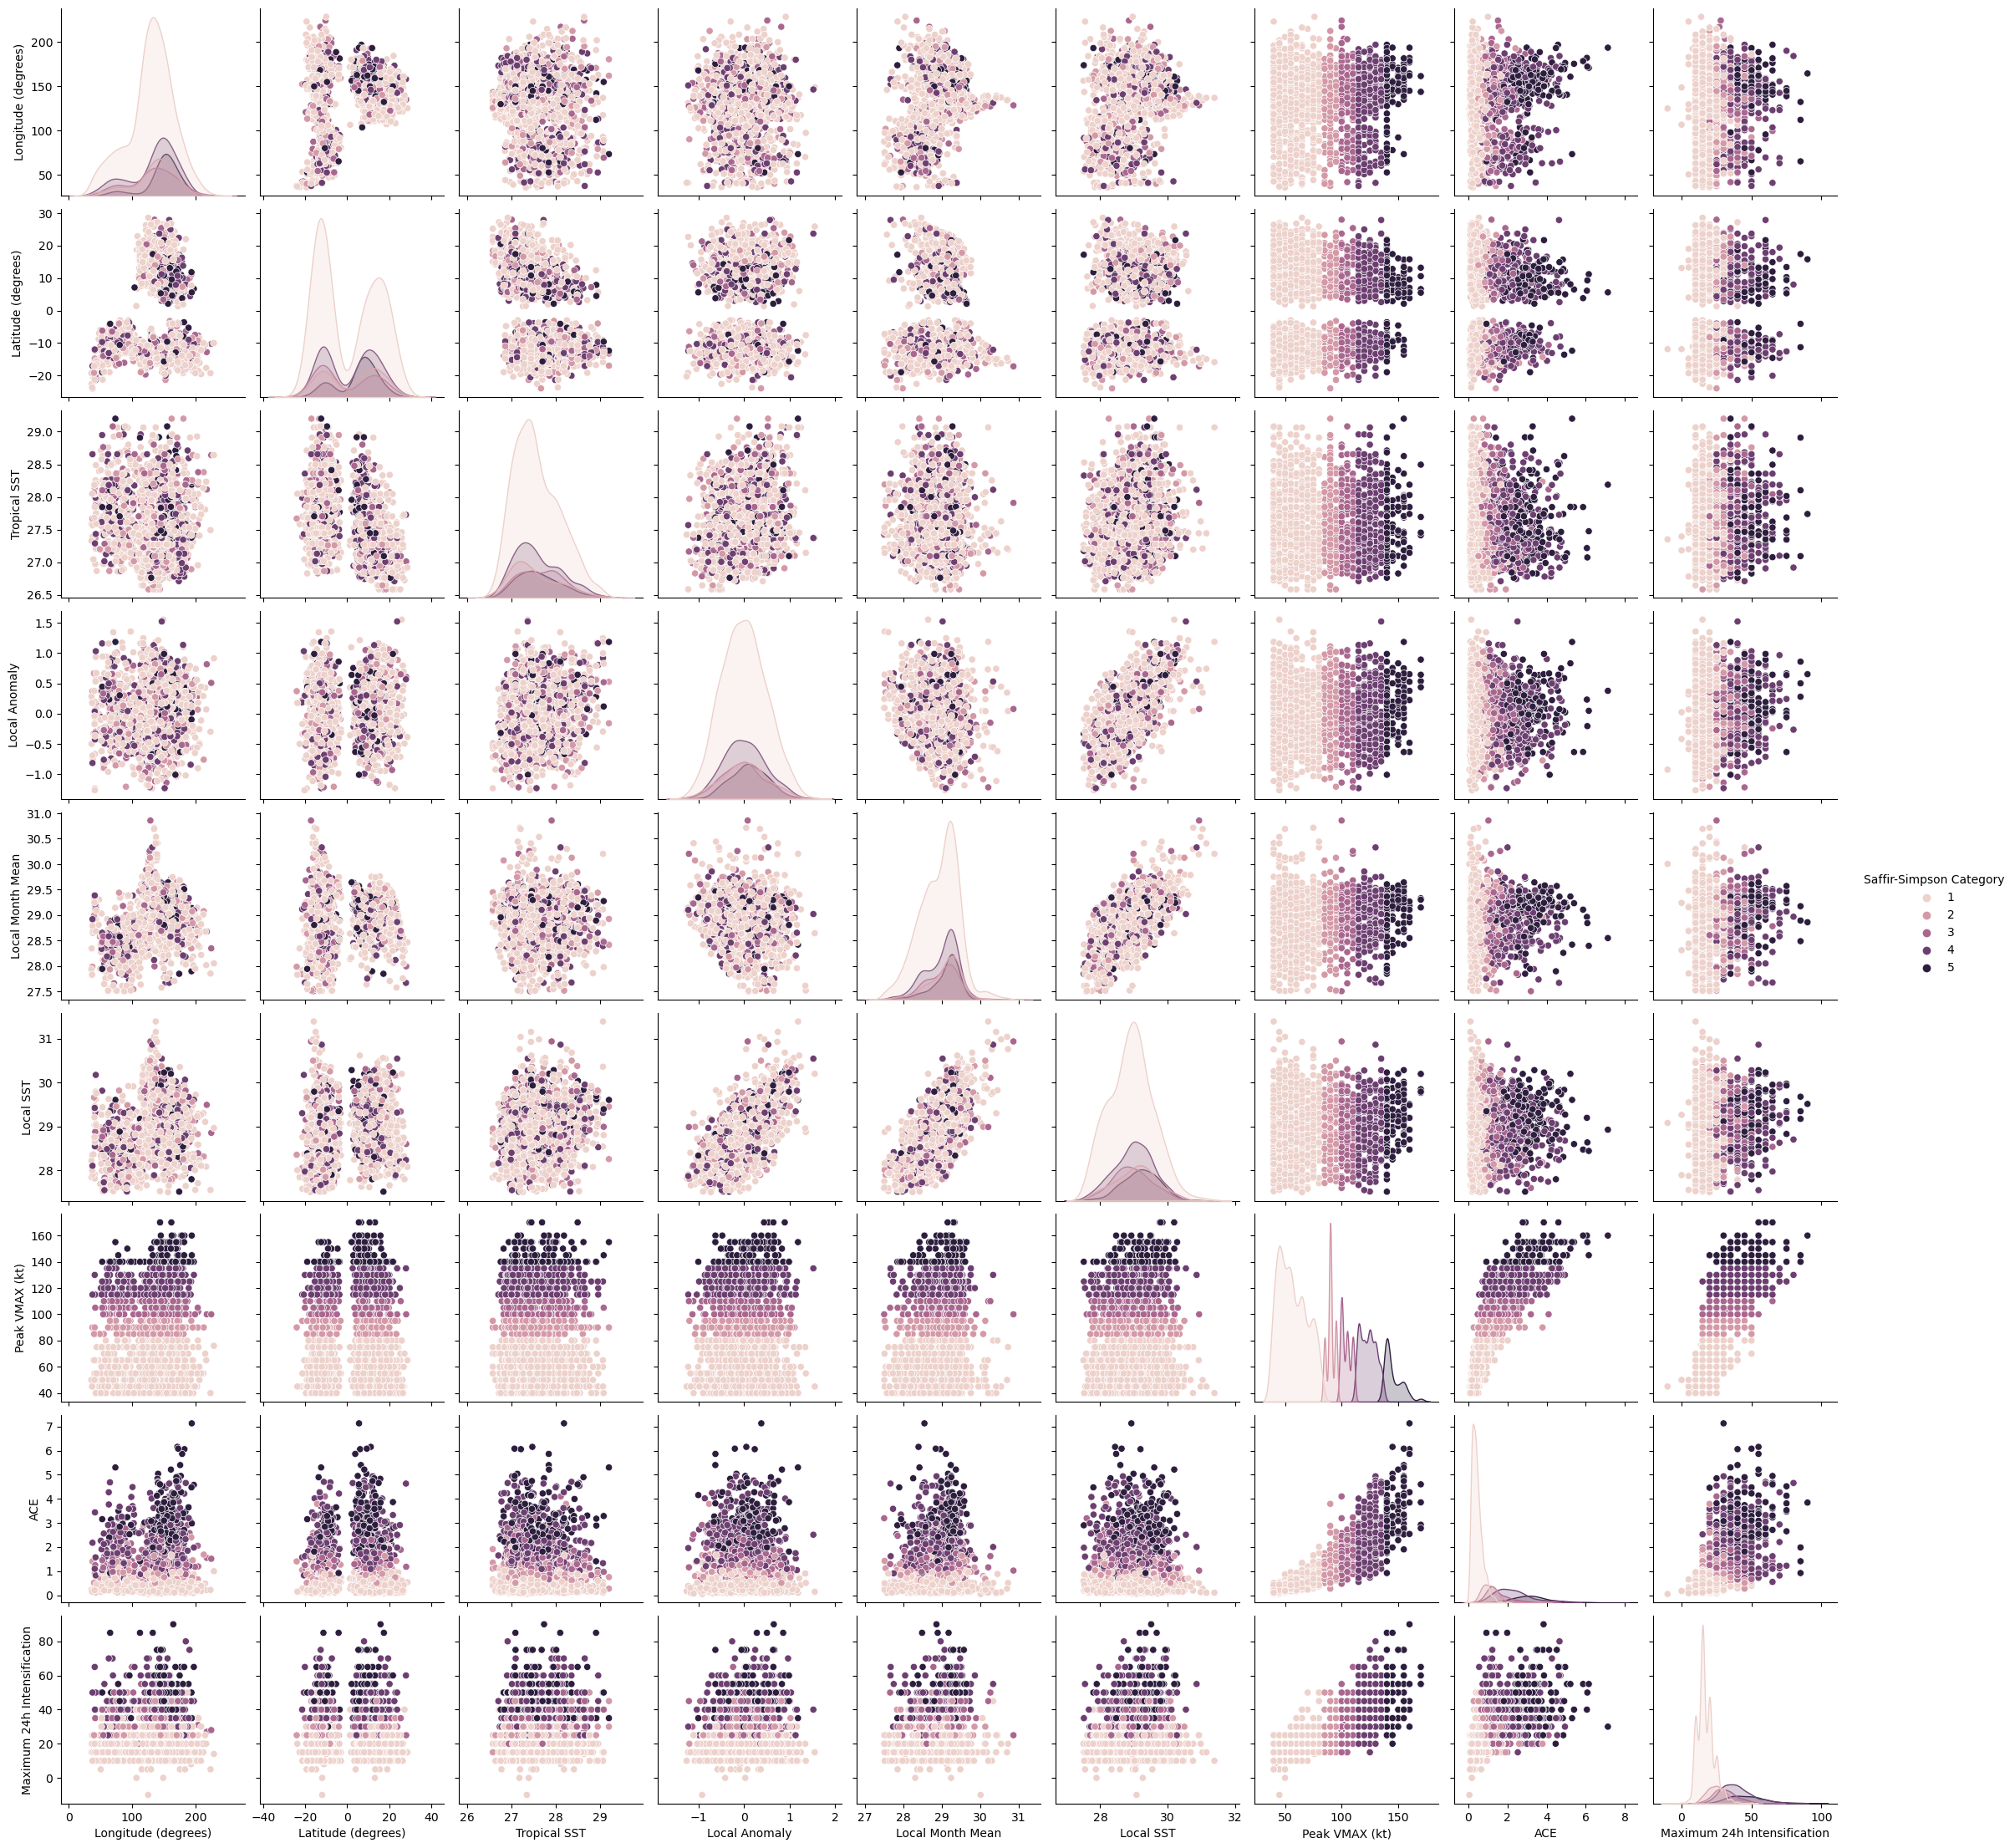

In [67]:

sns.pairplot(data=data_of_interest, hue='Saffir-Simpson Category')

In [68]:
basin_names = data_of_interest['BASIN'].unique()
print(basin_names)


# for basin_name in basin_names:
#     sns.pairplot(data= data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name], hue='Saffir-Simpson Category')
# # 




['WP' 'SI' 'SP']


WP
SI
SP


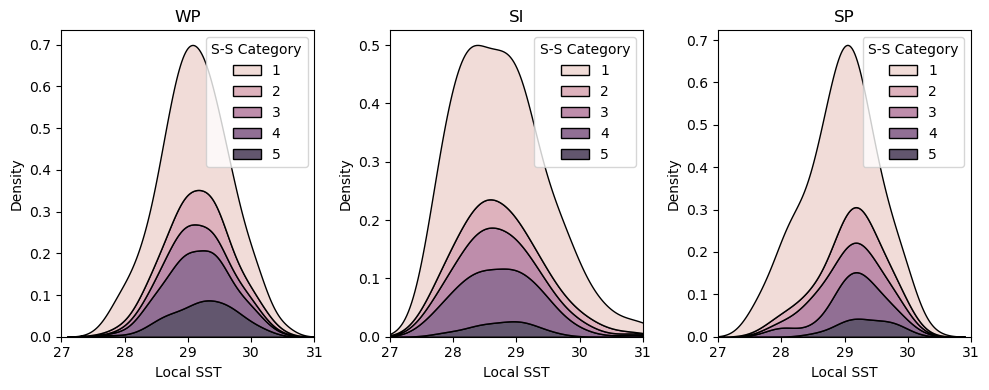

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

col = 0
for basin_name in basin_names:
    print(basin_name)
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Local SST',  ax=axs[col], hue='Saffir-Simpson Category', multiple='stack').set(title=basin_name)
    axs[col].get_legend().set(title='S-S Category')
    axs[col].set_xbound(27,31)
    col += 1

plt.tight_layout()

fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde.png')
plt.show()

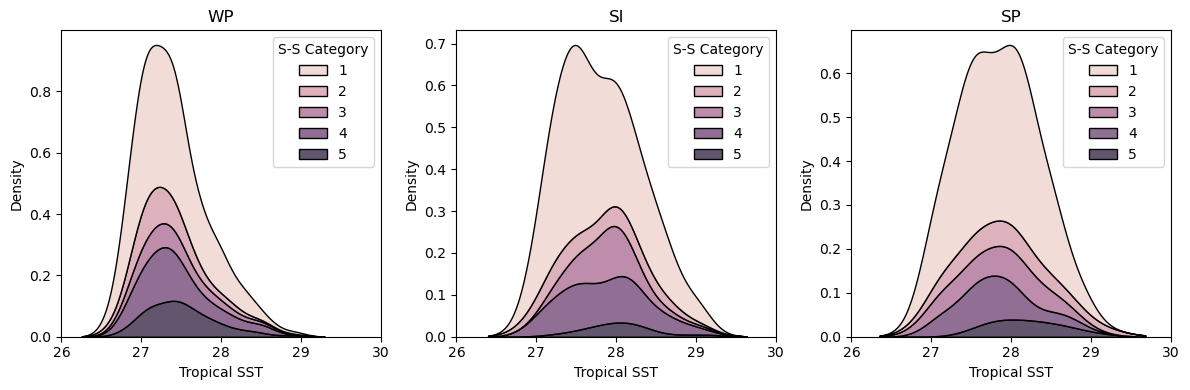

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

col = 0
for basin_name in basin_names:
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Tropical SST',  ax=axs[col], hue='Saffir-Simpson Category', multiple='stack').set(title=basin_name)
    axs[col].get_legend().set(title='S-S Category')
    axs[col].set_xbound(26,30)
    col += 1

plt.tight_layout()
fig.savefig('./media/cyclone_sst/new_basins/kde/tropical_kde.png')
plt.show()

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/975672589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/975672589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/975672589.py:6: SettingWithCopyWa

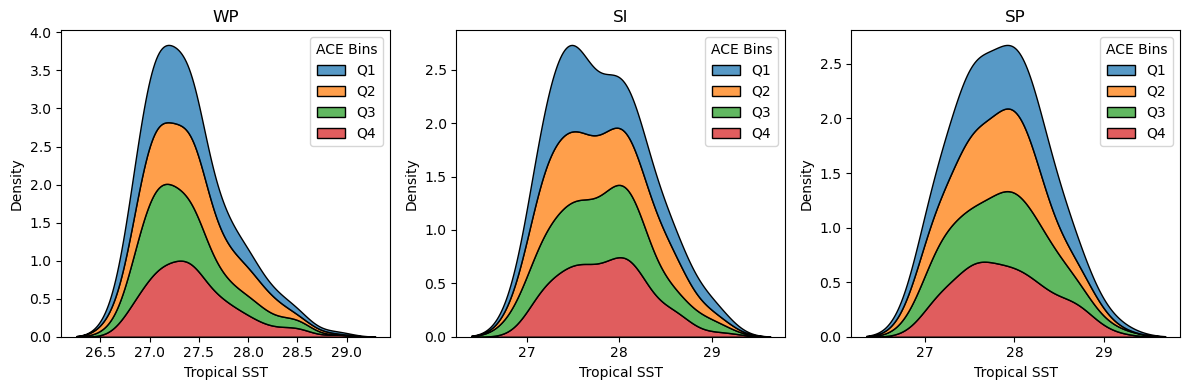

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

col = 0
for basin_name in basin_names:
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    sns.kdeplot(data=df, x='Tropical SST',  ax=axs[col], hue='ACE Bins', common_norm = False, multiple='stack').set(title=basin_name)
    col += 1

# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
# for row in range(len(df_mappings)):
#     for col in range(len(df_mappings[row])):
#         df_mappings[row][col]['df'].loc[:,'ACE Bins'] = pd.qcut(df_mappings[row][col]['df'].loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
#         sns.kdeplot(data=df_mappings[row][col]['df'], x='Tropical SST', ax=axs[row][col],hue='ACE Bins', common_norm=False, multiple='stack',color='magma').set(title=df_mappings[row][col]['name'])
#         axs[row][col].get_legend().set(title='Quartile')

# sns.kdeplot(data=si_df, x='Local Anomaly', ax=axs[0][0],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="South Indian")
# sns.kdeplot(data=sp_df,  x='Local Anomaly', ax=axs[0][1],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="South Pacific")
# sns.kdeplot(data=aus_df, x='Local Anomaly', ax=axs[1][0],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="Australia")
# sns.kdeplot(data=wp_df, x='Local Anomaly', ax=axs[1][1],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="West Pacific")
plt.tight_layout()
fig.savefig('./media/cyclone_sst/new_basins/kde/tropical_kde_ace.png')
plt.show()

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/1225075586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/1225075586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/1225075586.py:6: SettingWithCop

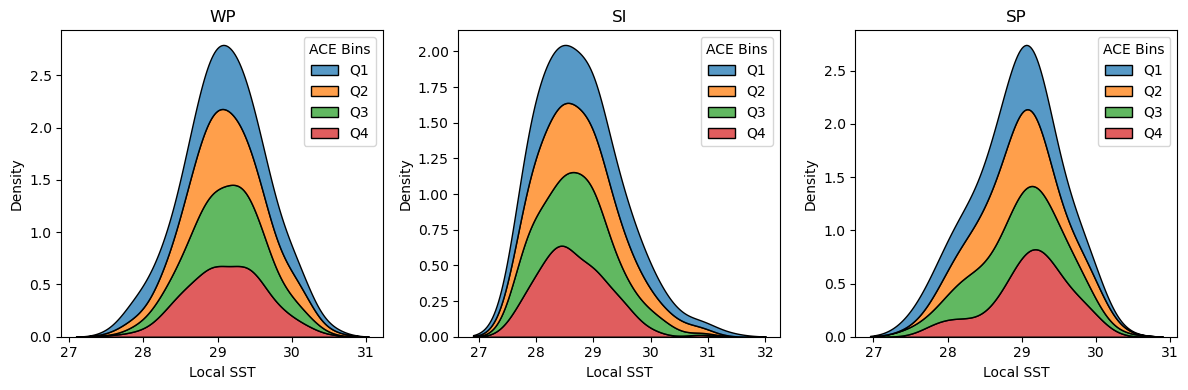

In [72]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

col = 0
for basin_name in basin_names:
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    df['ACE Bins'] =  pd.qcut(df.loc[:,'ACE'],q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    sns.kdeplot(data=df, x='Local SST',  ax=axs[col], hue='ACE Bins', common_norm = False, multiple='stack').set(title=basin_name)
    col += 1

# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
# for row in range(len(df_mappings)):
#     for col in range(len(df_mappings[row])):
#         df_mappings[row][col]['df'].loc[:,'ACE Bins'] = pd.qcut(df_mappings[row][col]['df'].loc[:,'ACE'],q=4,labels=['Q1', 'Q2', 'Q3', 'Q4'])
#         sns.kdeplot(data=df_mappings[row][col]['df'], x='Local SST', ax=axs[row][col],hue='ACE Bins', common_norm=False, multiple='stack').set(title=df_mappings[row][col]['name'])
#         axs[row][col].get_legend().set(title='Quartile')
        
# sns.kdeplot(data=si_df, x='Local Anomaly', ax=axs[0][0],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="South Indian")
# sns.kdeplot(data=sp_df,  x='Local Anomaly', ax=axs[0][1],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="South Pacific")
# sns.kdeplot(data=aus_df, x='Local Anomaly', ax=axs[1][0],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="Australia")
# sns.kdeplot(data=wp_df, x='Local Anomaly', ax=axs[1][1],  hue='Saffir-Simpson Category', common_norm=False, multiple='stack').set(title="West Pacific")
plt.tight_layout()
fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde_ace.png')
plt.show()

### TODO: effect of interaction between coordinates and lag 0 local rSST on cyclone severity.

In [73]:
## Rename columns for statsmodels
renamed_df = cyclone_df.copy()
renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
renamed_df

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/409357478.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_36694/409357478.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


timestamp   storm_id basin  season  season_tc_number  \
911   1982-03-14 06:00:00   1982-N-1    WP  1982.0               1.0   
0     1981-10-21 06:00:00   1982-S-2    SI  1982.0               2.0   
912   1982-03-18 06:00:00   1982-N-2    WP  1982.0               2.0   
913   1982-03-28 06:00:00   1982-N-3    WP  1982.0               3.0   
2     1981-12-05 00:00:00   1982-S-4    SI  1982.0               4.0   
...                   ...        ...   ...     ...               ...   
1877  2022-10-14 06:00:00  2022-N-24    WP  2022.0              24.0   
1878  2022-10-26 00:00:00  2022-N-26    WP  2022.0              26.0   
1879  2022-10-28 12:00:00  2022-N-27    WP  2022.0              27.0   
1880  2022-11-11 18:00:00  2022-N-28    WP  2022.0              28.0   
1881  2022-12-08 00:00:00  2022-N-29    WP  2022.0              29.0   

      latitude_degrees  longitude_degrees  vmax_kt  peak_vmax_kt      ace  \
911                7.1              153.0     15.0          60.0  0.73250   
0                 -8.0               84.6     40.0          85.0  1.18725   
912                3.8              160.7     25.0         105.0  2.02800   
913                3.5              156.6     20.0          75.0  0.70650   
2                -11.9              125.0     45.0          45.0  0.04850   
...                ...                ...      ...           ...      ...   
1877              26.4              154.4     25.0          40.0  0.19675   
1878              12.2              133.8     20.0          75.0  0.67825   
1879               8.0              140.4     25.0          40.0  0.10875   
1880              20.2              166.3     20.0          40.0  0.10600   
1881               6.4              133.1     15.0          50.0  0.17550   

      maximum_24h_intensification  tropical_sst  local_sst  local_month_mean  \
911                          15.0     27.961514  28.082220         28.562027   
0                            25.0     27.240122  28.012896         27.828356   
912                          25.0     27.961514  29.003502         28.968107   
913                          15.0     27.961514  28.872086         29.140408   
2                           -10.0     27.350914  29.079239         30.004629   
...                           ...           ...        ...               ...   
1877                         15.0     27.271444  28.137896         27.757618   
1878                         25.0     27.271444  29.645842         29.207081   
1879                         15.0     27.271444  29.821840         29.312254   
1880                         10.0     27.478075  28.148760         27.703903   
1881                         20.0     27.492897  29.715696         28.992960   

      local_anomaly  saffir-simpson_category  
911       -0.479807                        1  
0          0.184540                        2  
912        0.035395                        3  
913       -0.268322                        1  
2         -0.925390                        1  
...             ...                      ...  
1877       0.380278                        1  
1878       0.438761                        1  
1879       0.509586                        1  
1880       0.444857                        1  
1881       0.722736                        1  

[1811 rows x 16 columns]

## Quantile regression:
### Begin with all basins combined then split it up

In [104]:
# basic logistic regressor on lag 0 sst smoothed 
# TODO: Quantile regression -> top 10% of cyclones will look like??
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

## more regressions at higher quantiles
quantiles = np.arange(0.05, 0.96, 0.1)

def fit_model(quantile, model):
    res = model.fit(q=quantile)
    param_names = res.params.keys()
    # first one is intercept
    without_intercept = param_names[1:]
    ret_list = [quantile] + [res.params["Intercept"]] + [res.params[coefficient] for coefficient in without_intercept]
    for coefficient in without_intercept:
        ret_list += res.conf_int().loc[coefficient].tolist()

    return ret_list

def run_regression(df, response_var, ind_vars):
    model = smf.quantreg(f' {response_var}  ~ {" + ".join(ind_vars)}', data=df)
    models = [fit_model(x, model) for x in quantiles]
    models = pd.DataFrame(models, columns=["quantile"] + ["Intercept"] + [f"{var} Coefficient" for var in ind_vars] + [item for var in ind_vars for item in [f"{var} Lower", f"{var} Upper"]])
    return models


def plot_coefficients(models, ind_var, response_var, ax):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    return sns.regplot(data=models, x="quantile", y=f"{ind_var} Coefficient", ax=ax)
 

def plot_fit(df, models, ind_var, all_vars, response_var, ax):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    sns.scatterplot(data=df, x=ind_var, y=response_var, hue='saffir-simpson_category', alpha=0.4, ax=ax)
    var_x = np.linspace(df[ind_var].min(), df[ind_var].max(), 100)
    for i in range(models.shape[0]):    
        y = models["Intercept"][i] + models[f"{ind_var} Coefficient"][i] * var_x
        for other_var in all_vars:
            if other_var == ind_var:
                continue
            else:
                y += df[other_var].mean() * models[f"{other_var} Coefficient"][i]

        
        ax.plot(var_x, y, linestyle="dotted", color="grey")
    
    return ax
    

        
# def run_regression_and_plots(df, response_var, ind_vars,additional_title=None):
#     models = run_regression(df, response_var, ind_vars)
    
#     # GO THROUGH FOR EACH VARIABE AND PLOT SEPARATELY
    
#     col = 0
#     for ind_var in ind_vars
#         c = plot_coefficients(models=models, ind_var = ind_var, response_var = response_var, ax = ax[col])
#         col += 1
#     plt.save()

#     regression_figs = plot_fits(df, models, ind_vars, response_var)


#     for regression_fig in regression_figs:
#         fig = regression_fig['fig']
#         filename = regression_fig['filename']
#         if additional_title is not None:
#             filename += "_" + additional_title
#         plt.figure(fig)
#         plt.savefig(filename + '.png')
#         plt.show()

#     plot_fits(df, models, ind_vars, response_var)

   

# run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['tropical_sst'], additional_title=None)
# run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['local_sst'])



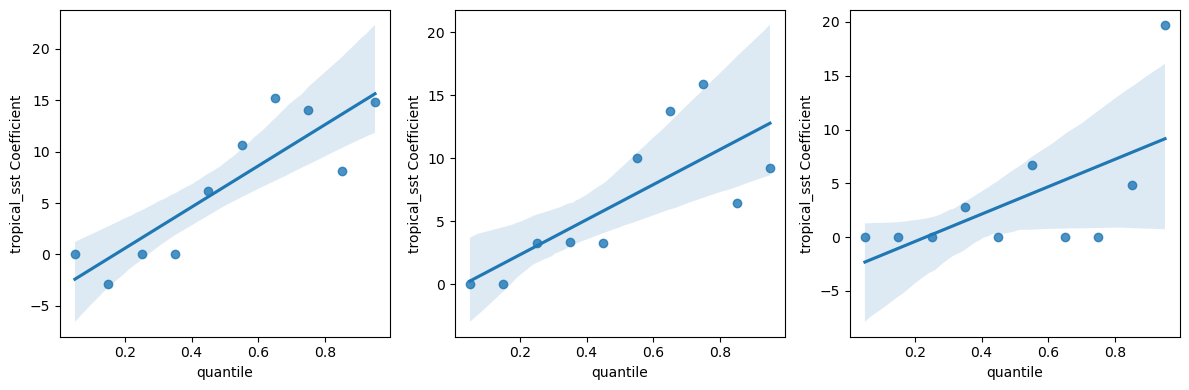

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (10

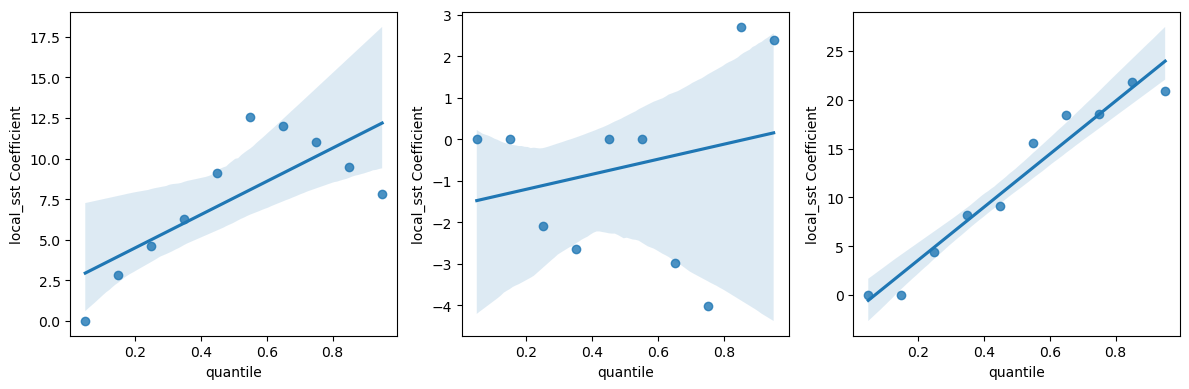

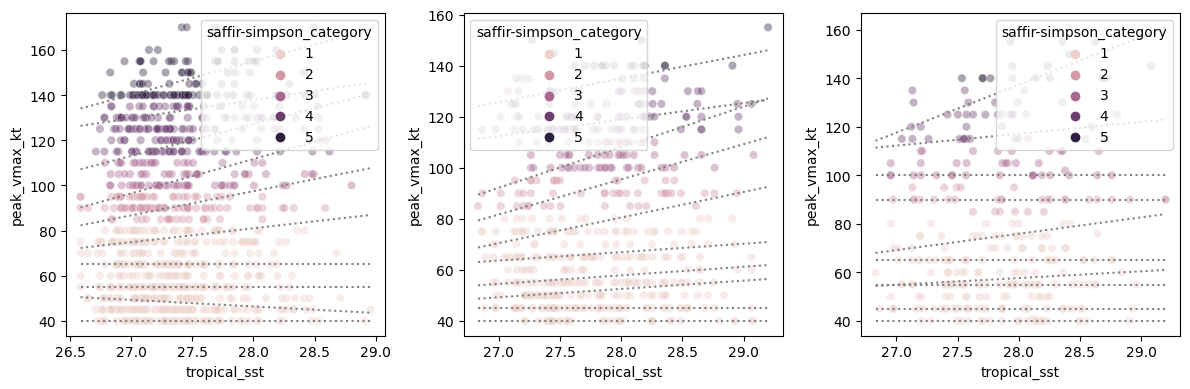

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (10

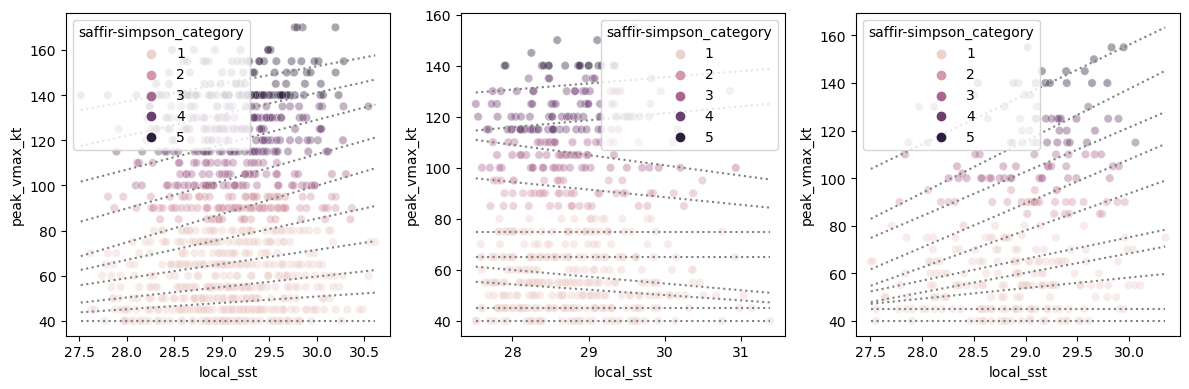

In [106]:
basin_dfs = {}

col=0
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
for basin_name in renamed_df['basin'].unique():
    basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
    models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['tropical_sst'])
    plot_coefficients(models, ind_var='tropical_sst', response_var='peak_vmax_kt', ax=axs[col])

    col += 1

plt.tight_layout()
plt.savefig('./media/freq_quantreg/new_basins/per_basin_tropical_sst_coefficients.png')
plt.show()


col=0
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
for basin_name in renamed_df['basin'].unique():
    basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
    models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['local_sst'])
    plot_coefficients(models, ind_var='local_sst', response_var='peak_vmax_kt', ax=axs[col])

    col += 1

plt.tight_layout()
plt.savefig('./media/freq_quantreg/new_basins/per_basin_local_sst_coefficients.png')
plt.show()


col=0
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
for basin_name in renamed_df['basin'].unique():
    basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
    models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['tropical_sst'])
    plot_fit(basin_df, models, ind_var='tropical_sst', all_vars = ['tropical_sst'], response_var='peak_vmax_kt', ax=axs[col])

    col += 1

plt.tight_layout()
plt.savefig('./media/freq_quantreg/new_basins/per_basin_tropical_sst_fit.png')
plt.show()


col=0
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
for basin_name in renamed_df['basin'].unique():
    basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
    models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['local_sst'])
    plot_fit(basin_df, models, ind_var='local_sst', all_vars=['local_sst'], response_var='peak_vmax_kt', ax=axs[col])

    col += 1

plt.tight_layout()
plt.savefig('./media/freq_quantreg/new_basins/per_basin_local_sst_fit.png')
plt.show()


# for df in [si_renamed, sp_renamed, wp_renamed]:
#     run_regression_and_plots(df, response_var='peak_vmax_kt', ind_vars=['tropical_sst', 'local_sst'], title=f'peak vmax {df["basin"].unique()[0]}')
#     run_regression_and_plots(df, response_var='ace', ind_vars=['tropical_sst', 'local_sst'],title=f'ace {df["basin"].unique()[0]}')





    # GO THROUGH FOR EACH VARIABE AND PLOT SEPARATELY



    # regression_figs = plot_fits(df, models, ind_vars, response_var)

    # for regression_fig in regression_figs:
    #     fig = regression_fig['fig']
    #     filename = regression_fig['filename']
    #     if additional_title is not None:
    #         filename += "_" + additional_title
    #     plt.figure(fig)
    #     plt.savefig(filename + '.png')
    #     plt.show()

    # plot_fits(df, models, ind_vars, response_var)





